In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes



=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



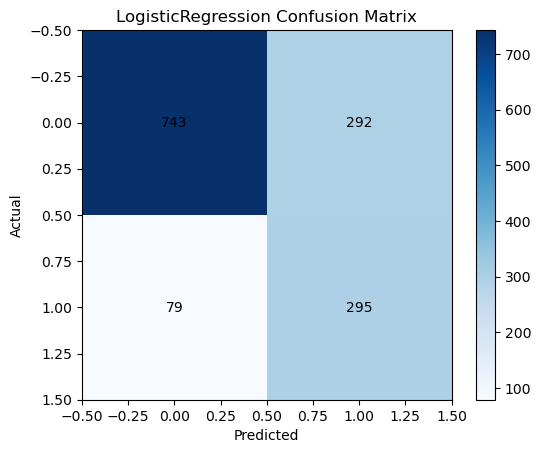

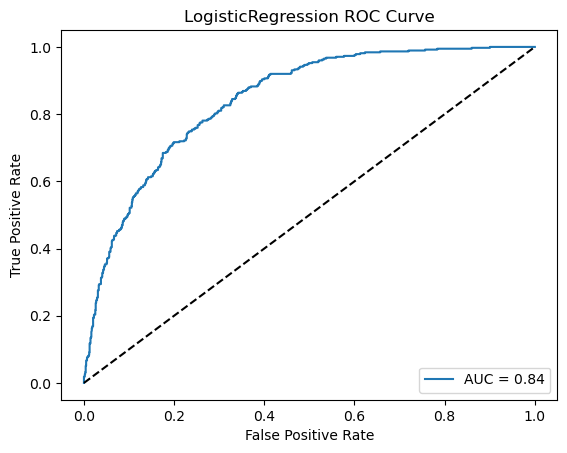


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.59      0.56      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



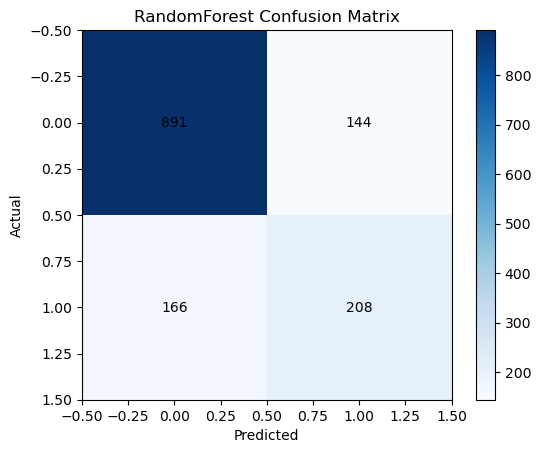

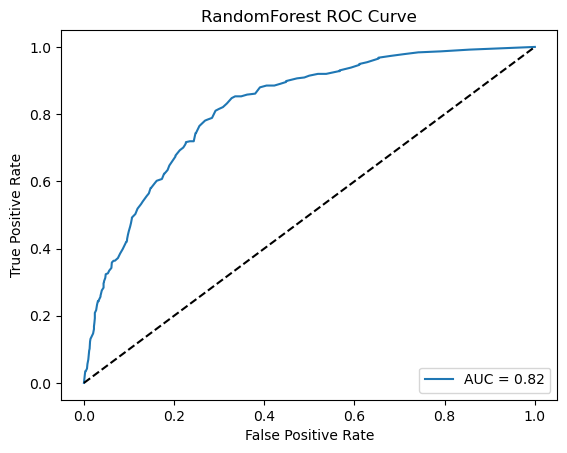


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1035
           1       0.55      0.66      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



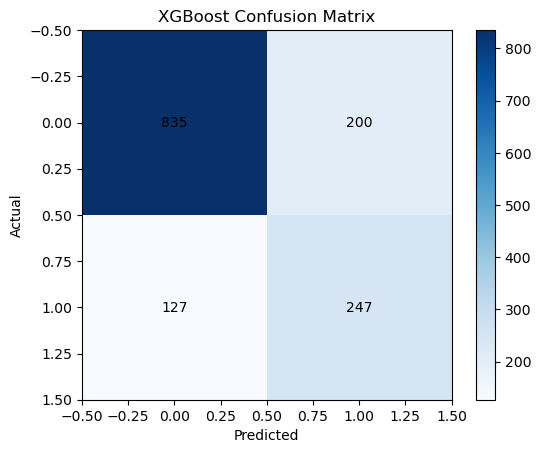

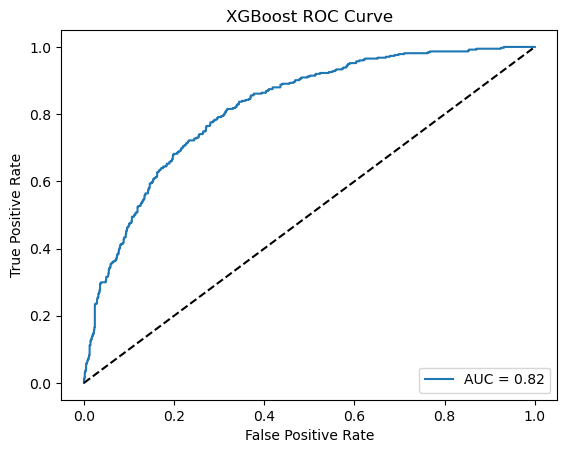

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 1. Load data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2. Data Cleaning & Feature Engineering
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.drop('customerID', axis=1, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,60, np.inf],
                            labels=['0-12','13-24','25-48','49-60','60+'])

# 3. Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Preprocessing pipelines
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_features = [col for col in X.columns if col not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Preprocess training data
X_train_pre = preprocessor.fit_transform(X_train)
# Combine for resampling
train_df = pd.DataFrame(X_train_pre.toarray() if hasattr(X_train_pre, "toarray") else X_train_pre)
train_df['target'] = y_train.values

# 5. Handle class imbalance via upsampling
df_majority = train_df[train_df.target == 0]
df_minority = train_df[train_df.target == 1]
df_minority_upsampled = resample(df_minority, replace=True,
                                 n_samples=len(df_majority), random_state=42)
train_bal = pd.concat([df_majority, df_minority_upsampled])
X_train_bal = train_bal.drop('target', axis=1)
y_train_bal = train_bal['target']

# Preprocess test data
X_test_pre = preprocessor.transform(X_test)

# 6. Modeling & Evaluation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_pre)
    y_prob = model.predict_proba(X_test_pre)[:, 1]
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.title(f'{name} Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
# app.py

import pandas as pd
import numpy as np
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')


def load_and_preprocess(csv_path: str) -> pd.DataFrame:
    """
    1. Read CSV.
    2. Convert TotalCharges to numeric; impute missing with median.
    3. Drop customerID.
    4. Binarize Churn (Yes→1, No→0).
    5. Create tenure_group categories.
    """
    df = pd.read_csv(csv_path)

    # Convert TotalCharges to numeric, fill missing with median
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    # Drop the ID column
    df.drop(columns=['customerID'], inplace=True)

    # Map Churn to 0/1
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Create tenure_group
    df['tenure_group'] = pd.cut(
        df['tenure'],
        bins=[0, 12, 24, 48, 60, np.inf],
        labels=['0-12', '13-24', '25-48', '49-60', '60+']
    )

    return df


def build_preprocessor(df: pd.DataFrame) -> ColumnTransformer:
    """
    Build a ColumnTransformer that:
    - Imputes numeric features with median & standardizes them.
    - Imputes categorical features with mode & one-hot encodes them.
    """
    numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_features = [col for col in df.columns if col not in numeric_features + ['Churn']]
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # Use sparse_output=False for scikit-learn ≥1.2
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor


def train_model(df: pd.DataFrame, preprocessor: ColumnTransformer) -> dict:
    """
    1. Split into train/test (stratified by Churn).
    2. Upsample minority class (Churn=1) in training.
    3. Fit a RandomForestClassifier.
    4. Compute predictions, probabilities, classification report, confusion matrix, ROC curve, AUC.
    Returns a dict containing model, X_test, y_test, y_pred, y_proba, report_dict, cm, roc_curve, roc_auc.
    """

    # Separate features/target
    X = df.drop(columns=['Churn'])
    y = df['Churn']

    # Fit & transform all features
    X_pre = preprocessor.fit_transform(X)

    # Build column names from numeric+onehot transformers
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    num_feature_names = preprocessor.named_transformers_['num'] \
        .named_steps['scaler'] \
        .get_feature_names_out(num_cols).tolist()

    cat_cols = [col for col in X.columns if col not in num_cols]
    cat_feature_names = preprocessor.named_transformers_['cat'] \
        .named_steps['onehot'] \
        .get_feature_names_out(cat_cols).tolist()

    feature_names = num_feature_names + cat_feature_names
    X_pre_df = pd.DataFrame(X_pre, columns=feature_names)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pre_df, y, test_size=0.2, random_state=42, stratify=y
    )

    # Upsample minority class in training set
    train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    df_majority = train_combined[train_combined['Churn'] == 0]
    df_minority = train_combined[train_combined['Churn'] == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )

    train_balanced = pd.concat([df_majority, df_minority_upsampled])
    X_train_bal = train_balanced.drop(columns=['Churn'])
    y_train_bal = train_balanced['Churn']

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_bal, y_train_bal)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Classification report as dict
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Confusion matrix (2×2)
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve + AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'report_dict': report_dict,
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr),
        'roc_auc': roc_auc
    }


# -----------------------------------------------
# 1. Load, preprocess, train once at startup
# -----------------------------------------------
df_raw = load_and_preprocess("WA_Fn-UseC_-Telco-Customer-Churn.csv")
preprocessor = build_preprocessor(df_raw)
trained = train_model(df_raw, preprocessor)

# Extract metrics
report_dict = trained['report_dict']
cm = trained['confusion_matrix']
fpr, tpr = trained['roc_curve']
roc_auc = trained['roc_auc']

# Convert classification report dict → DataFrame (for DataTable)
report_df = (
    pd.DataFrame(report_dict)
    .transpose()
    .reset_index()
    .rename(columns={'index': 'Metric'})
)


# -----------------------------------------------
# 2. Build Dash App
# -----------------------------------------------
app = dash.Dash(__name__)
app.title = "Customer Churn Dashboard (Dash)"

TENURE_GROUPS = sorted(df_raw['tenure_group'].dropna().unique().tolist())
CONTRACT_TYPES = sorted(df_raw['Contract'].dropna().unique().tolist())


app.layout = html.Div(
    style={'fontFamily': 'Arial, sans-serif', 'maxWidth': '1200px', 'margin': 'auto'},
    children=[
        html.H1("📊 Telco Customer Churn Dashboard", style={'textAlign': 'center', 'marginBottom': '20px'}),

        # — Filters —
        html.Div(
            style={'display': 'flex', 'justifyContent': 'space-between', 'marginBottom': '20px'},
            children=[
                html.Div([
                    html.Label("Filter by Tenure Group:"),
                    dcc.Dropdown(
                        id='tenure-filter',
                        options=[{'label': tg, 'value': tg} for tg in TENURE_GROUPS],
                        value=TENURE_GROUPS,
                        multi=True
                    ),
                ], style={'width': '48%'}),

                html.Div([
                    html.Label("Filter by Contract Type:"),
                    dcc.Dropdown(
                        id='contract-filter',
                        options=[{'label': c, 'value': c} for c in CONTRACT_TYPES],
                        value=CONTRACT_TYPES,
                        multi=True
                    )
                ], style={'width': '48%'}),
            ]
        ),

        # — Section 1: Churn Trends —
        html.H2("1. Churn Trends", style={'marginTop': '40px'}),
        html.Div(
            style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'space-between'},
            children=[
                html.Div([dcc.Graph(id='churn-by-tenure-group')], style={'width': '48%', 'marginBottom': '30px'}),
                html.Div([dcc.Graph(id='churn-over-tenure-months')], style={'width': '48%', 'marginBottom': '30px'}),
            ]
        ),

        # — Section 2: High-Risk Customer Groups —
        html.H2("2. High-Risk Customer Groups", style={'marginTop': '40px'}),
        html.Div(
            style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'space-between'},
            children=[
                html.Div([dcc.Graph(id='churn-by-contract')], style={'width': '48%', 'marginBottom': '30px'}),
                html.Div([dcc.Graph(id='churn-by-payment-method')], style={'width': '48%', 'marginBottom': '30px'}),
            ]
        ),

        # — Section 3: Model Accuracy & Performance —
        html.H2("3. Model Accuracy & Performance", style={'marginTop': '40px'}),
        html.Div(
            style={'display': 'flex', 'flexDirection': 'column', 'gap': '30px'},
            children=[
                # Classification Report Table
                html.Div([
                    html.H4("Classification Report"),
                    dash_table.DataTable(
                        id='classification-report-table',
                        columns=[{"name": i, "id": i} for i in report_df.columns],
                        data=report_df.to_dict('records'),
                        style_cell={'textAlign': 'center', 'padding': '5px'},
                        style_header={'backgroundColor': '#f2f2f2', 'fontWeight': 'bold'},
                        style_data_conditional=[{'if': {'row_index': 'odd'}, 'backgroundColor': '#f9f9f9'}],
                        page_size=6
                    )
                ]),

                # Confusion Matrix Heatmap
                html.Div([
                    html.H4("Confusion Matrix"),
                    dcc.Graph(
                        id='confusion-matrix-heatmap',
                        figure=go.Figure(
                            data=go.Heatmap(
                                z=cm,
                                x=['Predicted: No', 'Predicted: Yes'],
                                y=['Actual: No', 'Actual: Yes'],
                                colorscale='Blues',
                                showscale=True
                            )
                        )
                    )
                ]),

                # ROC Curve
                html.Div([
                    html.H4(f"ROC Curve (AUC = {roc_auc:.2f})"),
                    dcc.Graph(
                        id='roc-curve-plot',
                        figure=go.Figure(
                            data=[
                                go.Scatter(
                                    x=fpr, y=tpr, mode='lines', name=f'AUC = {roc_auc:.2f}',
                                    line=dict(color='darkorange', width=2)
                                ),
                                go.Scatter(
                                    x=[0,1], y=[0,1], mode='lines', name='Random Chance',
                                    line=dict(color='navy', width=1, dash='dash')
                                )
                            ],
                            layout=go.Layout(
                                xaxis=dict(title='False Positive Rate'),
                                yaxis=dict(title='True Positive Rate'),
                                showlegend=True
                            )
                        )
                    )
                ]),
            ]
        ),

        # Footer
        html.Hr(),
        html.Div("© 2025 Customer Churn Dashboard", style={'textAlign': 'center', 'color': '#888', 'marginTop': '20px'})
    ]
)


# -----------------------------------------------
# 3. Callbacks: update charts based on filters
# -----------------------------------------------
@app.callback(
    Output('churn-by-tenure-group', 'figure'),
    Output('churn-over-tenure-months', 'figure'),
    Output('churn-by-contract', 'figure'),
    Output('churn-by-payment-method', 'figure'),
    Input('tenure-filter', 'value'),
    Input('contract-filter', 'value'),
)
def update_charts(selected_tenures, selected_contracts):
    # Filter df_raw
    dff = df_raw.loc[
        df_raw['tenure_group'].isin(selected_tenures) &
        df_raw['Contract'].isin(selected_contracts)
    ]

    # 1A. Churn rate by tenure_group (bar)
    churn_by_tg = dff.groupby('tenure_group')['Churn'].mean().reset_index()
    fig_tg = px.bar(
        churn_by_tg,
        x='tenure_group',
        y='Churn',
        labels={'tenure_group': 'Tenure Group', 'Churn': 'Churn Rate'},
        title='Churn Rate by Tenure Group',
        color='Churn', color_continuous_scale='Blues'
    )
    fig_tg.update_layout(coloraxis_showscale=False)

    # 1B. Churn rate over tenure months (line)
    churn_over_t = dff.groupby('tenure')['Churn'].mean().reset_index()
    fig_t = px.line(
        churn_over_t,
        x='tenure',
        y='Churn',
        labels={'tenure': 'Tenure (months)', 'Churn': 'Churn Rate'},
        title='Churn Rate Over Tenure (Monthly)'
    )
    fig_t.update_traces(line=dict(color='darkblue'))

    # 2A. Churn rate by contract (bar)
    churn_by_ct = dff.groupby('Contract')['Churn'].mean().reset_index()
    fig_ct = px.bar(
        churn_by_ct,
        x='Contract',
        y='Churn',
        labels={'Contract': 'Contract Type', 'Churn': 'Churn Rate'},
        title='Churn Rate by Contract Type',
        color='Churn', color_continuous_scale='Oranges'
    )
    fig_ct.update_layout(coloraxis_showscale=False)

    # 2B. Churn rate by payment method (horizontal bar)
    churn_by_pm = dff.groupby('PaymentMethod')['Churn'].mean().reset_index()
    fig_pm = px.bar(
        churn_by_pm,
        x='Churn',
        y='PaymentMethod',
        orientation='h',
        labels={'PaymentMethod': 'Payment Method', 'Churn': 'Churn Rate'},
        title='Churn Rate by Payment Method',
        color='Churn', color_continuous_scale='Greens'
    )
    fig_pm.update_layout(coloraxis_showscale=False, yaxis={'categoryorder':'total ascending'})

    return fig_tg, fig_t, fig_ct, fig_pm


# -----------------------------------------------
# 4. Run Dash Server (updated)
# -----------------------------------------------
if __name__ == '__main__':
    # Replaces the old `app.run_server(debug=True)`
    app.run(debug=True)


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2. Data Cleaning & Feature Engineering
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df.drop('customerID', axis=1, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,60, np.inf],
                            labels=['0-12','13-24','25-48','49-60','60+'])

# 3. Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Preprocessing pipelines
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_features = [col for col in X.columns if col not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Preprocess training data
X_train_pre = preprocessor.fit_transform(X_train)
# Combine for resampling
train_df = pd.DataFrame(X_train_pre.toarray() if hasattr(X_train_pre, "toarray") else X_train_pre)
train_df['target'] = y_train.values

# 5. Handle class imbalance via upsampling
df_majority = train_df[train_df.target == 0]
df_minority = train_df[train_df.target == 1]
df_minority_upsampled = resample(df_minority, replace=True,
                                 n_samples=len(df_majority), random_state=42)
train_bal = pd.concat([df_majority, df_minority_upsampled])
X_train_bal = train_bal.drop('target', axis=1)
y_train_bal = train_bal['target']

# Preprocess test data
X_test_pre = preprocessor.transform(X_test)

# 6. Modeling & Evaluation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_pre)
    y_prob = model.predict_proba(X_test_pre)[:, 1]
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.title(f'{name} Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# 7. Export for BI tools
processed = preprocessor.transform(X)
pd.DataFrame(processed.toarray() if hasattr(processed, "toarray") else processed)\
  .to_csv('/mnt/data/processed_telco_churn.csv', index=False)
print("Exported processed features to /mnt/data/processed_telco_churn.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'